In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy.stats import gamma
from typing import Dict, Tuple

In [44]:
X_train = pd.read_csv("X_trn.csv")
y_train = pd.read_csv("y_trn.csv")

In [45]:
X_train = X_train[["year", "gender"]]

In [46]:
X_train["gender"] = np.where(X_train["gender"] == "Male", 1, 0)

In [47]:
X = X_train.copy()
X['y'] = y_train

In [48]:
import multiprocessing
import xgboost as xgb
from xgboostlss.distributions.Gamma import *
from xgboostlss.model import *

In [49]:
n_cpu = multiprocessing.cpu_count()
dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)

In [50]:
xgblss = XGBoostLSS(
    Gamma(stabilization="L2",     
          response_fn="exp",      
          loss_fn="crps"           
         )
)

In [51]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    "tree_method":    ["categorical", ["auto", "approx", "hist"]],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2025-10-03 10:54:18,484] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


   0%|          | 00:00/10:00

Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).


[I 2025-10-03 10:58:53,198] Trial 0 finished with value: 66912963.2 and parameters: {'eta': 0.11893932532367128, 'max_depth': 3, 'gamma': 2.5839448361291066, 'subsample': 0.31621777474182444, 'colsample_bytree': 0.31651707493900166, 'min_child_weight': 0.9011948620150002, 'booster': 'gbtree', 'tree_method': 'auto'}. Best is trial 0 with value: 66912963.2.


Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).


[I 2025-10-03 11:02:46,501] Trial 1 finished with value: 69941641.6 and parameters: {'eta': 0.0008259682973950845, 'max_depth': 8, 'gamma': 1.1298426516848201e-07, 'subsample': 0.6039167545897014, 'colsample_bytree': 0.30829813831242536, 'min_child_weight': 1.2903817691298097e-07, 'booster': 'gbtree', 'tree_method': 'approx'}. Best is trial 0 with value: 66912963.2.


Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).


[I 2025-10-03 11:04:19,039] Trial 2 finished with value: 70280451.2 and parameters: {'eta': 8.067529403881194e-05, 'max_depth': 5, 'gamma': 34.02257462720992, 'subsample': 0.3345019157742686, 'colsample_bytree': 0.9714425118273731, 'min_child_weight': 1.6224108340483295e-08, 'booster': 'gbtree', 'tree_method': 'approx'}. Best is trial 0 with value: 66912963.2.

Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  3
  Best trial:
    Value: 66912963.2
    Params: 
    eta: 0.11893932532367128
    max_depth: 3
    gamma: 2.5839448361291066
    subsample: 0.31621777474182444
    colsample_bytree: 0.31651707493900166
    min_child_weight: 0.9011948620150002
    booster: gbtree
    tree_method: auto
    opt_rounds: 61


In [ ]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).


In [53]:
pred_data_1980 = pd.DataFrame({
    'year': [1980, 1980],
    'gender': [1, 0]  # 1 = Male, 0 = Femaale
})

dpred_1980 = xgb.DMatrix(pred_data_1980)

pred_params_1980 = xgblss.predict(dpred_1980, pred_type="parameters")
print("Predicted parameters for 1980:")
print(pred_params_1980)

Predicted parameters for 1980:
   concentration      rate
0       1.472784  0.000059
1       1.100752  0.000073


In [ ]:
def metrics(concentration, rate):
    concentration = np.asarray(concentration)
    rate = np.asarray(rate)
    
    mean = concentration / rate
    variance = concentration / (rate ** 2)
    std = np.sqrt(variance)
    
    cv = 1 / np.sqrt(concentration)
    
    gini = 1 / (2 * np.sqrt(concentration))

    p90 = gamma.ppf(0.90, a=concentration, scale=1/rate)
    p10 = gamma.ppf(0.10, a=concentration, scale=1/rate)
    ratio_90_10 = p90 / p10
    
    return {
        'mean': mean,
        'std': std,
        'variance': variance,
        'cv': cv,  
        'gini': gini,
        'p90_p10_ratio': ratio_90_10,
        'concentration': concentration,
        'rate': rate
    }

In [ ]:
male_concentration = pred_params_1980.iloc[0, 0]
male_rate = pred_params_1980.iloc[0, 1]
female_concentration = pred_params_1980.iloc[1, 0]
female_rate = pred_params_1980.iloc[1, 1]

male_metrics = metrics(male_concentration, male_rate)
female_metrics = metrics(female_concentration, female_rate)

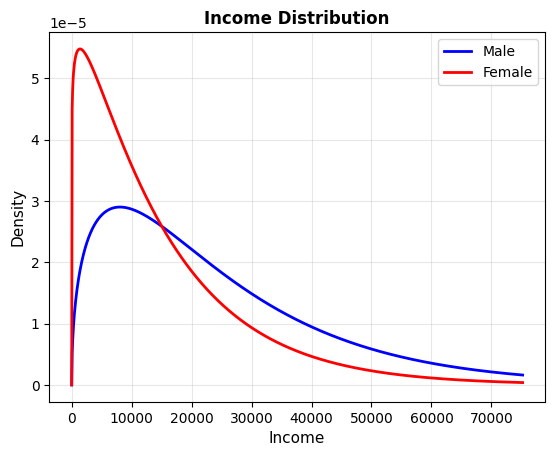

In [65]:
x_range = np.linspace(0, max(male_metrics['mean'] * 3, female_metrics['mean'] * 3), 1000)

male_pdf = gamma.pdf(x_range, a=male_metrics['concentration'], scale=1/male_metrics['rate'])
female_pdf = gamma.pdf(x_range, a=female_metrics['concentration'], scale=1/female_metrics['rate'])
    
plt.plot(x_range, male_pdf, label='Male', linewidth=2, color='blue')
plt.plot(x_range, female_pdf, label='Female', linewidth=2, color='red')
plt.xlabel('Income', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Income Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

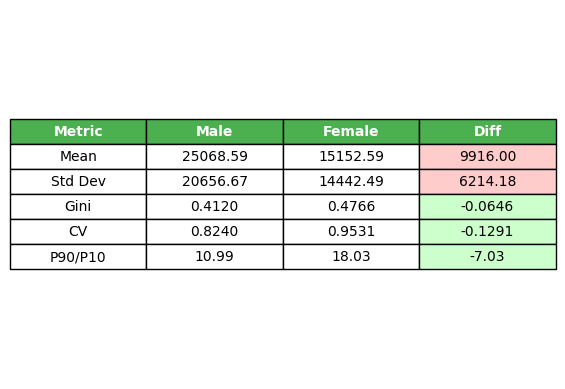

In [ ]:
summary_data = [
    ["Metric", "Male", "Female", "Diff"],
    ["Mean", f"{male_metrics['mean']:.2f}", f"{female_metrics['mean']:.2f}", f"{male_metrics['mean'] - female_metrics['mean']:.2f}"],
    ["Std Dev", f"{male_metrics['std']:.2f}", f"{female_metrics['std']:.2f}", f"{male_metrics['std'] - female_metrics['std']:.2f}"],
    ["Gini", f"{male_metrics['gini']:.4f}", f"{female_metrics['gini']:.4f}", f"{male_metrics['gini'] - female_metrics['gini']:.4f}"],
    ["CV", f"{male_metrics['cv']:.4f}", f"{female_metrics['cv']:.4f}", f"{male_metrics['cv'] - female_metrics['cv']:.4f}"],
    ["P90/P10", f"{male_metrics['p90_p10_ratio']:.2f}", f"{female_metrics['p90_p10_ratio']:.2f}", f"{male_metrics['p90_p10_ratio'] - female_metrics['p90_p10_ratio']:.2f}"],
]

table = plt.table(cellText=summary_data, loc='center', cellLoc='center', colWidths=[0.25]*4)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.5)

for j in range(4):
    table[(0, j)].set_facecolor("#4CAF50")
    table[(0, j)].set_text_props(weight="bold", color="white")

for i in range(1, len(summary_data)):
    diff = float(summary_data[i][3])
    table[(i, 3)].set_facecolor("#ffcccc" if diff > 0 else "#ccffcc")
plt.axis("off")
plt.show()

Question 2

Using 1000 Monte Carlo samples for each gender, what is the probability that a male
earned more than a female in 1980? How does it compare to 2010? Provide a figure
for each year and briefly explain your reasoning. The figure should show the histogram
of the Monte Carlo samples (consider the correct scale).


Comparing 1980 vs 2010

=== 1980 Results ===
Male   - Mean: $24,190, Median: $18,793
Female - Mean: $15,622, Median: $11,625
P(Male > Female) = 0.639 (63.9%)

=== 2010 Results ===
Male   - Mean: $24,363, Median: $18,702
Female - Mean: $15,958, Median: $11,630
P(Male > Female) = 0.628 (62.8%)

=== Summary ===
Change in P(Male > Female): -0.011 (-1.1 pp)
Gap narrowed from 1980 to 2010


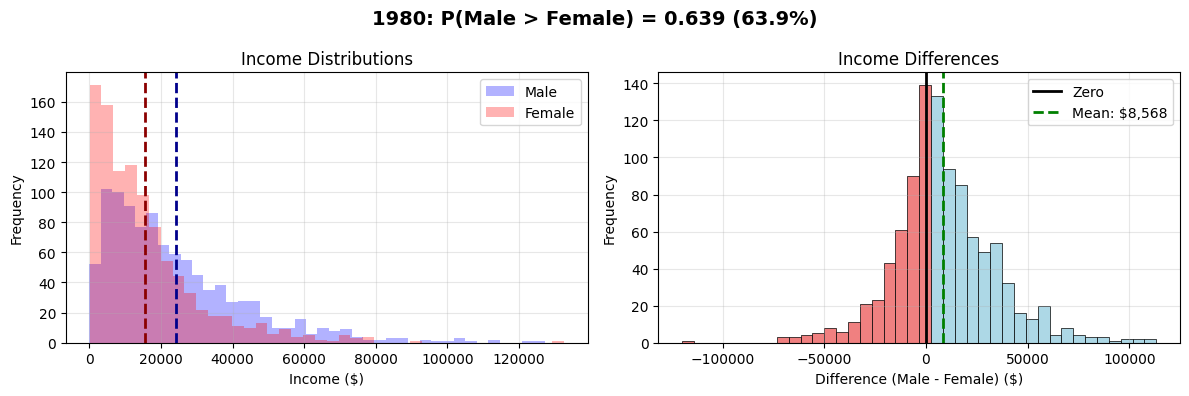

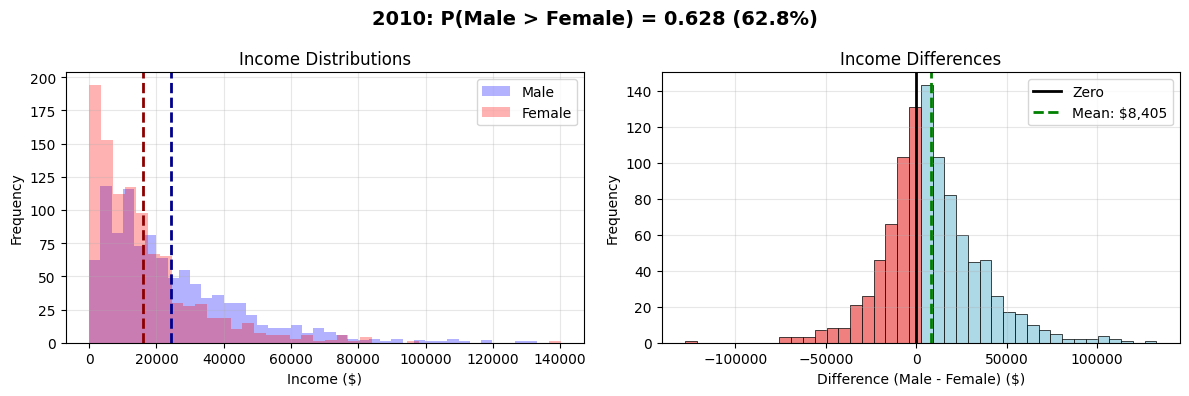

In [ ]:
def monte_carlo_income_comparison(xgblss_model, year, n_samples=1000, seed=123):
    np.random.seed(seed)
    
    pred_data = pd.DataFrame({
        'year': [year, year],
        'gender': [1, 0]  # 1=Male, 0=Female
    })
    
    params = xgblss_model.predict(xgb.DMatrix(pred_data), pred_type="parameters")
    male_conc, male_rate = params.iloc[0, 0], params.iloc[0, 1]
    female_conc, female_rate = params.iloc[1, 0], params.iloc[1, 1]
    
    male_samples = np.random.gamma(male_conc, 1/male_rate, n_samples)
    female_samples = np.random.gamma(female_conc, 1/female_rate, n_samples)
    
    prob = np.mean(male_samples > female_samples)
    
    print(f"\n=== {year} Results ===")
    print(f"Male   - Mean: ${np.mean(male_samples):,.0f}, Median: ${np.median(male_samples):,.0f}")
    print(f"Female - Mean: ${np.mean(female_samples):,.0f}, Median: ${np.median(female_samples):,.0f}")
    print(f"P(Male > Female) = {prob:.3f} ({prob*100:.1f}%)")
    
    return male_samples, female_samples, prob


def plot_comparison(male_samples, female_samples, prob, year):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{year}: P(Male > Female) = {prob:.3f} ({prob*100:.1f}%)', fontsize=14, fontweight='bold')
    
    ax1.hist(male_samples, bins=40, alpha=0.3, label='Male', color='blue')
    ax1.hist(female_samples, bins=40, alpha=0.3, label='Female', color='red')
    ax1.axvline(np.mean(male_samples), color='darkblue', linestyle='--', linewidth=2)
    ax1.axvline(np.mean(female_samples), color='darkred', linestyle='--', linewidth=2)
    ax1.set_xlabel('Income ($)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Income Distributions')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    diff = male_samples - female_samples
    counts, bins, patches = ax2.hist(diff, bins=40, edgecolor='black', linewidth=0.5)
    
    for i, patch in enumerate(patches):
        patch.set_facecolor('lightblue' if bins[i] >= 0 else 'lightcoral')
    
    ax2.axvline(0, color='black', linestyle='-', linewidth=2, label='Zero')
    ax2.axvline(np.mean(diff), color='green', linestyle='--', linewidth=2, 
                label=f'Mean: ${np.mean(diff):,.0f}')
    ax2.set_xlabel('Difference (Male - Female) ($)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Income Differences')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def compare_years(xgblss_model, year1=1980, year2=2010, n_samples=1000, seed=123):
    print(f"\nComparing {year1} vs {year2}")
    print("="*50)
    
    male_1, female_1, prob_1 = monte_carlo_income_comparison(xgblss_model, year1, n_samples, seed)
    male_2, female_2, prob_2 = monte_carlo_income_comparison(xgblss_model, year2, n_samples, seed)
    
    change = prob_2 - prob_1
    print(f"\n=== Summary ===")
    print(f"Change in P(Male > Female): {change:+.3f} ({change*100:+.1f} pp)")
    print(f"Gap {'widened' if change > 0 else 'narrowed'} from {year1} to {year2}")
    
    plot_comparison(male_1, female_1, prob_1, year1)
    plot_comparison(male_2, female_2, prob_2, year2)
    
    return (male_1, female_1, prob_1), (male_2, female_2, prob_2)

results = compare_years(xgblss, year1=1980, year2=2010, n_samples=1000, seed=123)